In [10]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import pandas as pd

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import utils


# from ctapipe.io import read_table
# from astropy.table import vstack, Table
# # from lstchain.io.io import dl1_params_lstcam_key, dl1_images_lstcam_key
# # from lstchain.io.io import dl1_params_tel_mon_ped_key, dl1_params_tel_mon_cal_key, dl1_params_tel_mon_flat_key
# import matplotlib.pyplot as plt
# import numpy as np

# from ctapipe.visualization import CameraDisplay
# from ctapipe.coordinates import EngineeringCameraFrame
# from ctapipe.instrument import SubarrayDescription
# from ctapipe.containers import EventType

from ctapipe.io import read_table
from astropy.coordinates import SkyCoord
from traitlets.config.loader import Config
from lstchain.io.config import get_standard_config

# compute_dl1b

# Some configurations

In [11]:
# Source specifications
source_name = "crab"

# Maybe we add a way to extract the run numbers we are interested in
run_numbers = [15272,6172] # [6172, 6242, 6194, 6193, 15337, 15272, 15339, 15340] # [15272] # [15337, 15272]

# Paths to data and results

In [12]:
# Root path of this script
root = "/fefs/aswg/workspace/juan.jimenez/lst_pipeline/"
# Path to store the configuration file we are going to use
config_file = root + "objects/standard_config.json"
# Data main directory
root_data = root + f"../data/tests/{source_name}/"

# STANDARD paths ---------
# DL1 data root
dl1_root = "/fefs/aswg/data/real/DL1/*/v0.*/tailcut84/"
# RFs root main directory
rfs_root = "/fefs/aswg/data/models/AllSky/20230901_v0.10.4_allsky_base_prod/"
# MCs dl2 main directory
mcs_root = "/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/"


# directories for the data
dir_dl1b = root_data + "dl1b/"
dir_dl2  = root_data + "dl2/"
dir_dl3  = root_data + "dl3/"
dir_irfs = root_data + "irfs/"


# Creating the directories in case they don't exist
for path in [config_file, dir_dl1b, dir_dl2, dir_dl3, dir_irfs]:
    if not os.path.exists(path):
        os.makedirs(os.path.join(path), exist_ok=True)

# Opening and storing configuration file

In [13]:
config_dict = get_standard_config()
# print(config_dict)

#-------------------
# Changes in the configuration should be done here

# We select the heuristic flatfield option in the standard configuration
config_dict["source_config"]["LSTEventSource"]["use_flatfield_heuristic"] = True

#-------------------

with open(config_file, 'w') as json_file:
    json.dump(config_dict, json_file)

# Finding the files that interest us
#### Extracting dl1 files and dl1 datachecks

In [14]:
# Getting coordinates of source
source_coords = SkyCoord.from_name(source_name)

dict_source = {
    "name"   : source_name,
    "coords" : source_coords,
    "ra"     : source_coords.ra.deg  * u.deg, # ra in degrees
    "dec"    : source_coords.dec.deg * u.deg, # dec in degrees
}

# We create a empty dictionary to store all the information needed inside
DICT = {}
for run in run_numbers:
    DICT[run] = {
        "run_num" : run,
        "errors"  : "", # log of errors trough the analysis
    }

DICT = utils.add_dl1_paths_to_dict(DICT, dl1_root)
DICT = utils.add_dl1_paths_to_dict(DICT, dl1_root, dchecking=True)


Adding dl1  data to dictionary...
...Finished adding dl1 data to dictionary

Adding dl1 datacheck data to dictionary...
...Finished adding dl1 data to dictionary


#### Then we read the observations information and also the selected nodes for MC and RFs and we add it to the DICT

In [15]:
%%time
for run in run_numbers:

    tab = read_table(DICT[run]["dchecks"]["runwise"], "/dl1datacheck/cosmics")
    
    # reading the variables
    _zd,     _az       = 90 - np.rad2deg(np.array(tab["mean_alt_tel"])), np.rad2deg(np.array(tab["mean_az_tel"]))
    _t_start, _t_elapsed = tab["dragon_time"][0][0],                       np.array(tab["elapsed_time"])
    
    DICT[run]["time"] = {
        "tstart"   : _t_start,            # datetime object
        "telapsed" : np.sum(_t_elapsed),  # s
        "srunwise" : {
            "telapsed" : _t_elapsed,      # s      
        },
    }
    DICT[run]["pointing"] = {
        "zd" : np.mean(_zd),  # deg
        "az" : np.mean(_az),  # deg
        "srunwise" : {
            "zd" : _zd,       # deg
            "az" : _az,       # deg
        },
    }
    
# then we also select the RFs and MC files looking at the nodes available
DICT, dict_nodes = utils.add_mc_and_rfs_nodes(DICT, rfs_root, mcs_root, dict_source)

CPU times: user 324 ms, sys: 123 ms, total: 446 ms
Wall time: 4.55 s


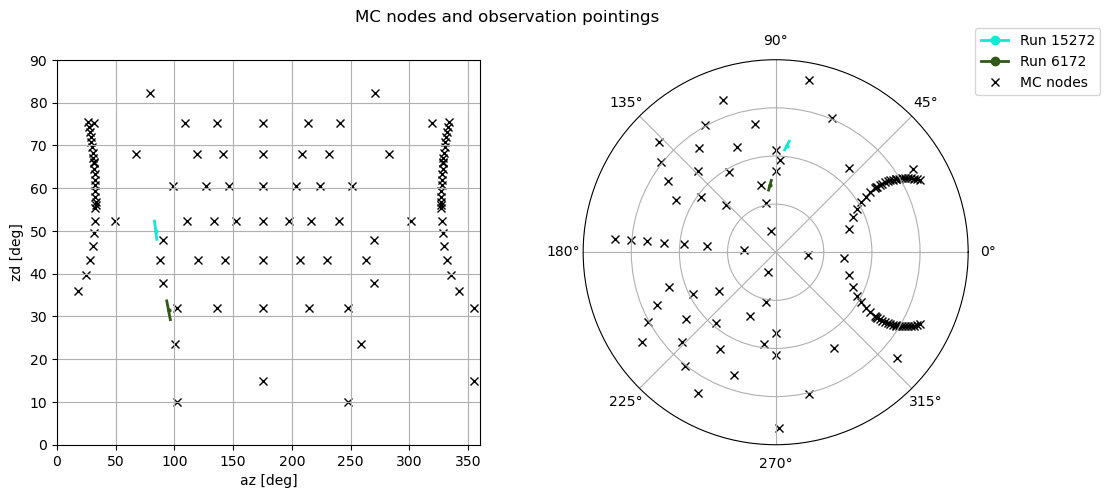

In [16]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle("MC nodes and observation pointings")
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="polar")

colors = [np.random.rand(3) for _ in range(len(run_numbers))] # random color for each run
for method, ax in zip([np.array, np.deg2rad], [ax1, ax2]):
    for i, run in enumerate(run_numbers):
        
        ax.plot(method(DICT[run]["pointing"]["srunwise"]["az"]), DICT[run]["pointing"]["srunwise"]["zd"], marker="",  color=colors[i], ls="-", lw=2)
        ax.plot(method(DICT[run]["pointing"]["az"]),             DICT[run]["pointing"]["zd"],             marker="o", color=colors[i], ls="",  ms=2)
 
        ax.plot([], [], marker="o", ls="-", lw=2, color=colors[i], label=f"Run {run}")
    ax.plot(method(dict_nodes["pointing"]["az"]), dict_nodes["pointing"]["zd"], marker="x", ls="", color="k", zorder=-10, label="MC nodes")

for ax in [ax1, ax2]:
    ax.grid(True, zorder=-100)
    ax.set_ylim(0, 90)
ax1.set_xlim(0, 360)
ax2.legend(loc="upper left", bbox_to_anchor=(1, 1.1))
ax2.set_yticks([22.5, 45, 67.5], [])
ax1.set_xlabel("az [deg]")
ax1.set_ylabel("zd [deg]")
plt.show()

# DL1a to DL1b

In [17]:
%%time
for ir, run in enumerate(DICT.keys()):

    sruns = [int(path.split(".")[-2]) for path in DICT[run]["dl1a"]["srunwise"]]
    DICT[run]["dl1b"] = {"srunwise" : []}

    for i, srun in enumerate(sruns):

        input_fname  = DICT[run]["dl1a"]["srunwise"][i]
        output_fname = dir_dl1b + f"dl1_LST-1.Run{run:05}.{srun:04}.h5"

        print(f"Computing dl1b Run {run:5} Subrun {srun:04} - {i/len(sruns)*100:3.1f}% sruns {ir+1}/{len(DICT.keys())} runs")
        print(f"--> {output_fname}\n")

#         !lstchain_dl1ab \
#           -f $input_fname \
#           -o $output_fname \
#           -c $config_file \
#           --no-image \

        DICT[run]["dl1b"]["srunwise"].append(output_fname)

Computing dl1b Run 15272 Subrun 0000 - 0.0% sruns 1/2 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl1b/dl1_LST-1.Run15272.0000.h5

Computing dl1b Run 15272 Subrun 0001 - 2.6% sruns 1/2 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl1b/dl1_LST-1.Run15272.0001.h5

Computing dl1b Run 15272 Subrun 0002 - 5.1% sruns 1/2 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl1b/dl1_LST-1.Run15272.0002.h5

Computing dl1b Run 15272 Subrun 0003 - 7.7% sruns 1/2 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl1b/dl1_LST-1.Run15272.0003.h5

Computing dl1b Run 15272 Subrun 0004 - 10.3% sruns 1/2 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl1b/dl1_LST-1.Run15272.0004.h5

Computing dl1b Run 15272 Subrun 0005 - 12.8% sruns 1/2 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl1b/dl1_LST-1.Run15272.0005.h5

Computing dl1b Run 15272 S

# DL1b to DL2

In [25]:
for ir, run in enumerate(DICT.keys()):
    
    sruns = [int(path.split(".")[-2]) for path in DICT[run]["dl1a"]["srunwise"]]
    DICT[run]["dl2"] = {"srunwise" : []}
    
    for i, srun in enumerate(sruns):

        input_fname  = DICT[run]["dl1b"]["srunwise"][i]
        output_fname = dir_dl2 + input_fname.split("/")[-1].replace("dl1", "dl2", 1)
        rf_node      = DICT[run]["simulations"]["rf"]
        
        print(f"Computing dl1b Run {run:5} Subrun {srun:04} - {i/len(sruns)*100:3.1f}% sruns {ir+1}/{len(DICT.keys())} runs")
        print(f"--> {output_fname}\n")
        
#         !lstchain_dl1_to_dl2 \
#           -f $input_fname \
#           -p $rf_node \
#           -o $dir_dl2 \
#           -c $config_file \
    
        DICT[run]["dl2"]["srunwise"].append(output_fname)

Computing dl1b Run 15272 Subrun 0000 - 0.0% sruns 1/2 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl2/dl2_LST-1.Run15272.0000.h5

Computing dl1b Run 15272 Subrun 0001 - 2.6% sruns 1/2 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl2/dl2_LST-1.Run15272.0001.h5

Computing dl1b Run 15272 Subrun 0002 - 5.1% sruns 1/2 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl2/dl2_LST-1.Run15272.0002.h5

Computing dl1b Run 15272 Subrun 0003 - 7.7% sruns 1/2 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl2/dl2_LST-1.Run15272.0003.h5

Computing dl1b Run 15272 Subrun 0004 - 10.3% sruns 1/2 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl2/dl2_LST-1.Run15272.0004.h5

Computing dl1b Run 15272 Subrun 0005 - 12.8% sruns 1/2 runs
--> /fefs/aswg/workspace/juan.jimenez/lst_pipeline/../data/tests/crab/dl2/dl2_LST-1.Run15272.0005.h5

Computing dl1b Run 15272 Subrun 

# DL2 merging run-wise

# MCs to IRFs

# DL2 to DL3

## Add DL3 index files

In [ ]:
# source_ra  = f"{source_coords.ra.deg}deg"
# source_dec = f"{source_coords.dec.deg}deg"